#Introduction to simple Neural Networks

By: Guillaume De Gani

In [ ]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.models import Sequential, Input
import numpy as np
from tensorflow import keras
import pandas as pd
from keras.layers import Concatenate
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import keras
np.random.seed(20)

# Source :
The data was created by Dr. Wolberg, each record represents follow-up data for one breast cancer case. These are consecutive patients seen by Dr. Wolberg since 1984, and include only those cases exhibiting invasive breast cancer and no evidence of distant metastases at the time of diagnosis. 

# Data Specs:
The data is composed of 198 entries from various patients, 4 entries had NaN's for certain features. Theses row were manually removed since the dataset is small enough to open and edit in NotePad.

Columns are not named to help with readability I named a few of them manually, sadly the features are not explicit enough to be named. 

The format is .data where each row represents an entry and the features are seperated by a comma. Most of the data is made of Floats except for one column which could cause problems further on.

# The Task
The goal of my model is to calculate the Time the patient had the tumour given a list of feautures describing the mamographie and wether or not the patient is in remision.

In [ ]:
#Creating Header For Readability
header_custom = ["Id", "Outcome","Time"]
for i in range(1,33):
header_custom.append("feature" + str(i))

#Parameter initialization


#Appending Data from Local computer
df = pd.read_csv(r"D:\Users\Guillaume\Desktop\wpbc.data", delimiter=",",names=header_custom)
data = df.drop(columns=["Id"],axis=1)




#Cheking linear corelation

Using pearson corelation you can analyze if the continous data studied has any linked features. The matrice bellow shows that there are no hyper-correlated parameters.
Except around features 21 to 24 which seem fairly corelated to eachoter. Since we don't know explicitly what the are it's hard to give an explanation for this corelation.

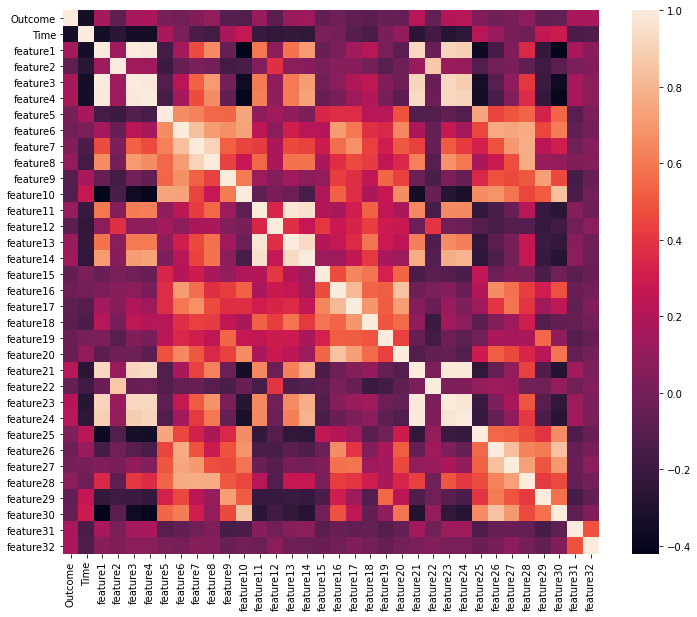

In [ ]:
corr_df = data.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=False)
plt.show()

In [ ]:
df.head()

,Id,Outcome,Time,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32
0,119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,0.1086,...,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5
1,8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2
2,842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,0.1255,...,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0
3,843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0
4,843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0


# Features Information :

- `Id` an Integer that identifies each patient
- `Outcome` a Char representhig whether or not the cancer is recuring or non recuring
- `Time` an Integer that represent the time with tumour in recuring and without if non recuring
- `feature1-32` Ten real-valued features are computed for each cell nucleus which are radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry and fractal dimension.

To use the model bellow it is imortant that the data is normalized

In [ ]:
#Changing char data ton int to prevent error
data.Outcome = data.Outcome.replace(to_replace=['N', 'R'], value=[0, 1])

#Normalization of the data
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

#Splitting Labeled and Non labeled data
X = data.drop(columns=["Time"],axis=1)
Y = data["Time"]

#Conver to float
X = np.asarray(X).astype('float32')
Y = np.asarray(Y).astype('float32')

#Creation of train and test split
X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), test_size = 0.20)

#Tuning the model

An important factor when creating a NN is the composition of the hidden layers, this is critical for the model to work properly. However very little is known on how to decide how many layer and neurons to use.

The folloing section tries to fix this by creating multiple NN and evaluating them to try and find a good solution to the problem. It is important to note that this solution isn't ideal since it requires a lot of computation time.  

In [ ]:
#Function That Creates and Neural Network
def createNN(neuronsPerLayer=8,numberOfLayers=1):
  hiddenLayerList = []
  dropoutHiddenLayerList = []
  inputs = Input(shape=(33,))
  #input Layer in1
  in1 = Dense(8, activation='linear', name='layer1')(inputs)
  #Dropout layers are added to avoid over fitting
  d1 = tf.keras.layers.Dropout(.2)(in1)
  for i in range(numberOfLayers): 
    if i == 0:
      hiddenLayerList.append(Dense(16, activation='relu')(d1))
      dropoutHiddenLayerList.append(tf.keras.layers.Dropout(.2)(hiddenLayerList[0]))
    else:
      hiddenLayerList.append(Dense(16, activation='relu')(dropoutHiddenLayerList[i-1]))
      dropoutHiddenLayerList.append(tf.keras.layers.Dropout(.2)(hiddenLayerList[i]))

  #Add Outpuet Layer
  mu = Dense(1, activation='linear', name='mu')(hiddenLayerList[len(hiddenLayerList)-1])
  sigma = Dense(1, activation='exponential',name='sigma')(hiddenLayerList[len(hiddenLayerList)-1])
  outputs = Concatenate(name='output')([mu, sigma])
  return keras.Model(inputs=inputs, outputs=outputs, name='last_layer')


#Function That Creates a list of Neural Networks
def createListOfNN(minNeuronsLayer=4,stepNeuronsLayer=4,maxNeuronsLayer=8,minLayers=1,stepLayers=1,maxLayers=1):
  out = []
  for numLayers in range(minLayers,maxLayers+1,stepLayers):
    for numNeurons in range(minNeuronsLayer,maxNeuronsLayer+1,stepNeuronsLayer):
      out.append([str(numLayers) + ' layers and ' + str(numNeurons) + ' neurons per layer.',createNN(numNeurons,numLayers)]) 
  return out

Here we define a custom loss function using the following formula:

$$ J(\hat{y}_{i,j}, \hat{\sigma}_{i,j}) = \frac{1}{2N} \sum_{ij} \left ( \left (\frac{y_{i,j} - \hat{y}_{i,j}}{\hat{\sigma}_{i,j}}\right )^2  + log(\hat{\sigma}_{i,j}^2) + 2log(\sqrt{2\pi}) \right )  $$

In [ ]:
#Custom Loss Function
def loss_mle(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        mean_true = y_true[...,:n1]
        mean_pred, std_pred = y_pred[...,:n1], y_pred[...,n1:]
        # Max to prevent NaN's and Inf's
        log_std = tf.math.log(tf.maximum(std_pred,tf.math.sqrt(tf.keras.backend.epsilon())))
        sq_std = tf.maximum(tf.square(std_pred),tf.keras.backend.epsilon() )
        mse = tf.math.squared_difference(mean_pred, mean_true) / (2*sq_std)
        loss = log_std + mse
        loss = tf.reduce_sum(loss, -1)
        return loss

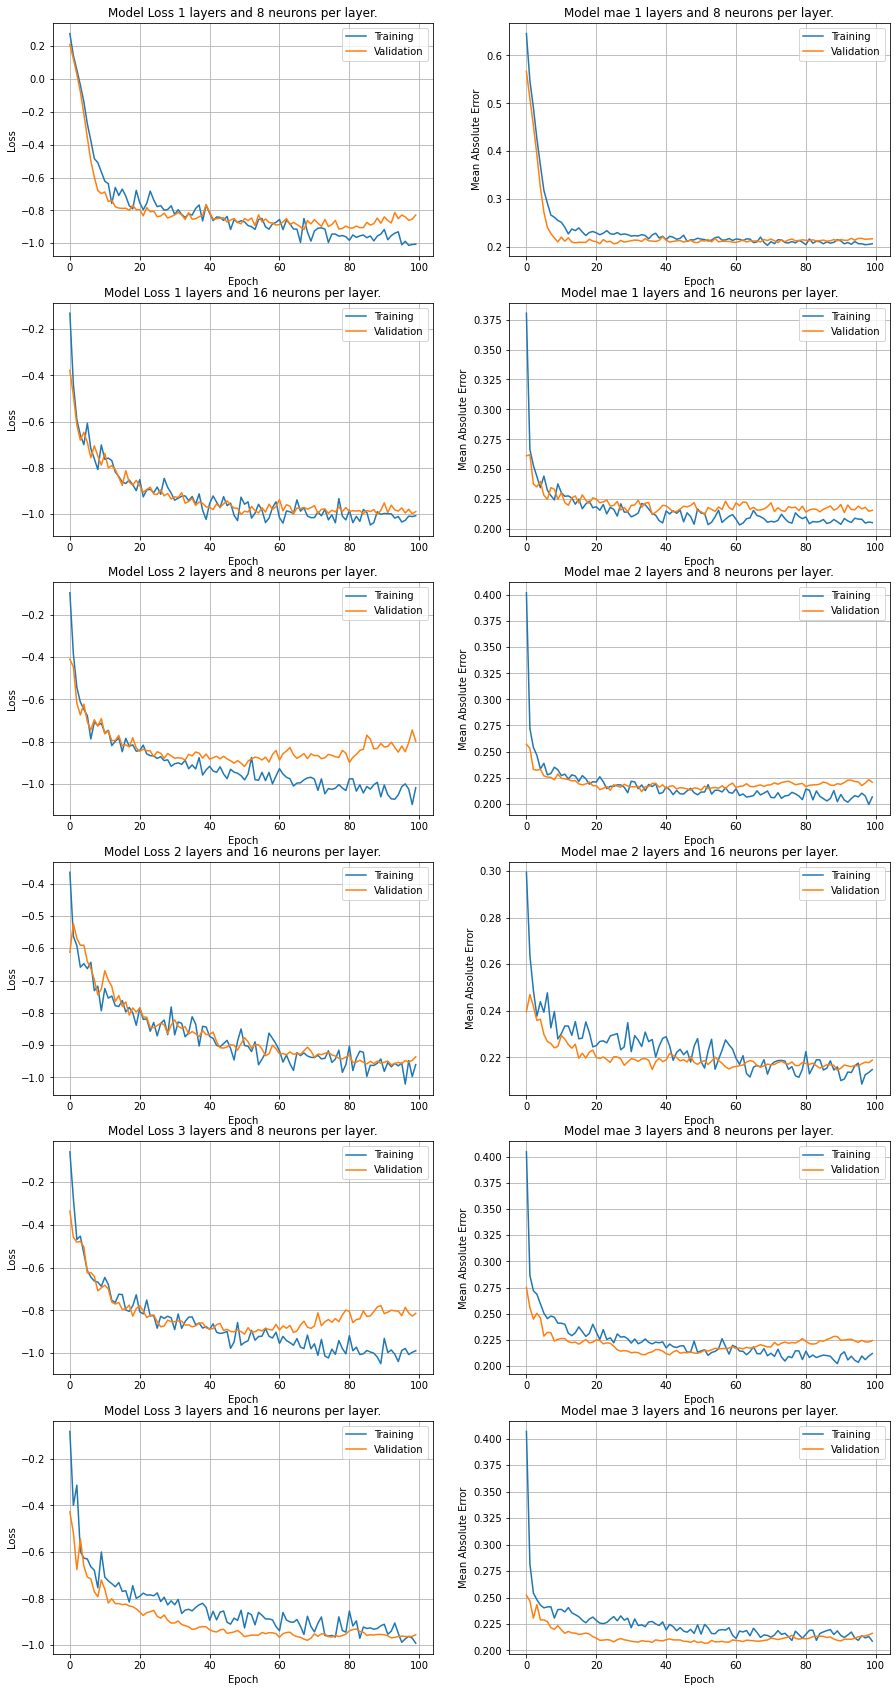

In [ ]:
list_models = []
#Creations of a list of models
list_models = createListOfNN(8,8,16,1,1,3)
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

fig = plt.subplots(1,2, figsize=(15,30))

from sklearn.metrics import mean_squared_error
listOfSpecs = []

#Iteration threw the models 
for i in range(len(list_models)):
  list_models[i][1].compile(optimizer=opt,loss=loss_mle, metrics=['mae'])
  history = list_models[i][1].fit(X_train,Y_train , epochs=100, batch_size=10, validation_data = (X_test, Y_test), verbose = 0)

  ax = plt.subplot(len(list_models),2,2*i+1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
  ax.plot(history.history['loss'])
  ax.plot(history.history['val_loss'])
  ax.set_title('Model Loss ' + list_models[i][0] )
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.legend(['Training', 'Validation'])
  ax.grid()
    
  ax = plt.subplot(len(list_models),2,2*i+2)
  ax.plot(history.history['mae'])
  ax.plot(history.history['val_mae'])
  ax.set_title('Model mae ' + list_models[i][0])
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Absolute Error')
  ax.legend(['Training', 'Validation']);   
  ax.grid()
  
  #Initialization of the data
  a = list_models[i][1].predict(X_test)
  SE= np.square(a[:,0]-np.ravel(Y_test))
  RSE= np.sqrt(SE)

  #Appending the specs to a list to print in table later
  listOfSpecs.append([list_models[i][0],mean_squared_error(Y_test, a[:,0], squared=False),np.std(SE),(np.sum(RSE<a[:,1])/len(Y_test)),(np.sum(RSE<2*a[:,1])/len(Y_test)),(np.sum(RSE<3*a[:,1])/len(Y_test))])


It's important to note that for some models the Validation loss seems to be increasing towards the end of the training process this is usually due to over fitting. This can be cause by multiple factors but in this case the cause is probably the size of ou dataset since 194 entries is no alot for our model.

In [ ]:
#Function to create HTML table below
def showTable(dataList):
  out = '<table border="1"><tbody>'
  out+= '<tr><td style="text-align: center; vertical-align: middle;" >Hidden Layer Layout</td><td style="text-align: center; vertical-align: middle;" >Root Mean Square Error</td><td style="text-align: center; vertical-align: middle;" >Sigma 1</td><td style="text-align: center; vertical-align: middle;" >Sigma 2</td><td style="text-align: center; vertical-align: middle;">Sigma 3</td></tr>'
  for lines in dataList:
    out+= '<tr>'
    for i in range(len(lines)):
      if i == 0:
        out+= '<td style="text-align: center; vertical-align: middle;" >' + str(lines[0]) + '</td>'
      if i == 1: 
        out+= '<td style="text-align: center; vertical-align: middle;" > ' + str("%.2f" % lines[1]) +' '+ u"\u00B1" + ' ' + str("%.2f" % lines[2]) + ' </td>'
      if i == 3:
        out+= '<td style="text-align: center; vertical-align: middle;" > ' + str("%.2f" % lines[3]) + '</td>'  
      if i == 4:
        out+= '<td style="text-align: center; vertical-align: middle;" > ' + str("%.2f" % lines[4]) + '</td>'  
      if i == 5:  
        out+= '<td style="text-align: center; vertical-align: middle;" > ' + str("%.2f" % lines[5]) + '</td>'  
        out+= '</tr>' 
        break
    
  out+= '</table></tbody>'
  return out

from IPython.display import display
display({'text/html': '<h1>Score table</h1>' + showTable(listOfSpecs), 'text/plain': '101'}, raw=True)

Hidden Layer Layout,Root Mean Square Error,Sigma 1,Sigma 2,Sigma 3
1 layers and 8 neurons per layer.,0.26 ± 0.10,0.67,0.90,0.97
1 layers and 16 neurons per layer.,0.24 ± 0.08,0.79,0.97,1.00
2 layers and 8 neurons per layer.,0.24 ± 0.08,0.74,0.95,0.97
2 layers and 16 neurons per layer.,0.24 ± 0.07,0.67,0.95,1.00
3 layers and 8 neurons per layer.,0.25 ± 0.09,0.74,0.95,0.97
3 layers and 16 neurons per layer.,0.24 ± 0.08,0.74,0.97,1.00


Now to select the model, we should choose the simplest one with the best score. In this case, the model with 1 layer and 16 neurons has the lowest RMSE in conjecture with the lowest deviation and finally a score above 75% on the predicted Sigma.

To go further it would've a been possible using a similare process to evaluate the diffrent Hyperparameters and there impact on the model like: 
- `Number of Epochs`
- `Learnig rate of the Optimizer`
- `Dropout rate for each layer`
- `Batch Sizes`
- `Loss Function`

However the problem of defining the strucure of the model is in my opinion the most intersesting aspect of Deep Learning and Neural Networks. 

#Conclusion

The dataset used was fairly small but the simple neural network created was still able to asses the duration of the illness with a error of less that 30%.

However this could've been improved by tuning more hyperparameters or if possible by using a larger dataset.